In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import yaml
import shap
import ipywidgets as widgets
import tensorflow as tf
import warnings
import os 
import sys

from matplotlib.pyplot import pie, axis, show
from sklearn.ensemble import RandomForestRegressor
from tabulate import tabulate
from sklearn.multioutput import RegressorChain, MultiOutputRegressor
from sklearn import linear_model

from tensorflow import keras
from xgboost.sklearn import XGBRegressor
from catboost import CatBoostRegressor
import lightgbm as ltb

# Get the directory of the current notebook
notebook_dir = os.path.dirname(os.path.abspath("__file__"))

# Define the relative path to the helper.py file
helper_path = os.path.abspath(os.path.join(notebook_dir, "../"))

# Add the helper directory to sys.path
sys.path.append(helper_path)

from helper import preprocess, get_test_train_data, get_features_kbest, get_features_ref, get_features_ref_multiout,\
    get_features_relieff, get_model_name, cross_val, get_scores, outlier_detect, train_models, pred_all,\
    find_lowest_respponse_value, find_highest_respponse_value, find_closest_to_42, check_aggreement,\
    get_concordant_discordant, print_change_mean, get_perc, percentage_change_original_data, calculate_percentage_change,\
    calculate_percentage_change_othre_responses, calculate_count_diff, calculate_change_diff, check_distribution,\
    drug_class_visualization, drug_class_outlier_remove, plot_scatter_with_CI, plot_scatter, save_data_for_ensemble,\
    get_feature_importance

warnings.filterwarnings('ignore')
%matplotlib inline

is_train_with_all=False 
isshap = False
# Read common variables from a YAML file
with open('../common_variables.yaml', 'r') as file:
    common_data = yaml.safe_load(file)
    
response_variable_list = common_data['response_variable_list']

correlated_variables = common_data['correlated_variables']

thresh = common_data['thresh']
keep = []
rem = []
# feature selection
items = ['drug_class']



In [2]:
def run(algo, i):
    df_X_train = pd.read_csv('../resources/data/imputed_all_training_data_wo_ldl.csv', sep = ',',decimal = '.', encoding = 'utf-8', engine ='python',index_col=0)
    df_X_test = pd.read_csv('../resources/data/testing_all_data_wo_ldl.csv', sep = ',',decimal = '.', encoding = 'utf-8', engine ='python',index_col=0)
    
    X_train_ = preprocess(df_X_train, response_variable_list)
    X_test_ = preprocess(df_X_test, response_variable_list)
    df, X_train, X_test, Y_train, Y_test, X, Y, scaler, X_test_before_scale = get_test_train_data(X_train_, X_test_, response_variable_list)

    # # train with whole dataset and test with drug class 2,3 and 4 data
    if(is_train_with_all):
        combined_df = pd.concat([X_test, Y_test], axis=1)
        testdf = combined_df[ 
                             (combined_df['drug_class'] == 0.25) | 
                             (combined_df['drug_class'] == 0.375) ]
        X_test = testdf.drop([response_variable_list], axis = 1)
        Y_test = testdf[response_variable_list]

    X_test_original = X_test.copy()
    X_train_original = X_train.copy()
    

    if(is_train_with_all):
        sglt_val = 0.375
        dpp_val = 0.25
    else:
        sglt_val = 1
        dpp_val = 0


    X_test_ = pd.DataFrame(X_test)
    X_train_ = pd.DataFrame(X_train)

    X_train = X_train.drop(['init_year'], axis = 1)
    X_test = X_test.drop(['init_year'], axis = 1)

    selected_features = []
    
    random.seed(42) 
    if algo == 'kbest':
        for j in range(Y_train.shape[1]):  # Assuming Y.shape[1] is the number of target features
            random.seed(42)
            feats = get_features_kbest(X_train, Y_train.iloc[:, j],i)
            selected_features.append(feats)
    elif algo == 'relieff':
        for j in range(Y_train.shape[1]):  # Assuming Y.shape[1] is the number of target features
            random.seed(42)
            feats = get_features_relieff(X_train, Y_train.iloc[:, j],i)
            selected_features.append(feats)
    elif algo == 'refMulti':
        random.seed(42)
        selected_list = get_features_ref_multiout(X_train, Y_train, i)
    elif algo=='ref':
        random.seed(42)
        for j in range(Y_train.shape[1]):  # Assuming Y.shape[1] is the number of target features
            feats = get_features_ref(X_train, Y_train.iloc[:, j],i)
            selected_features.append(feats)
    else:
       
        # REF 6 features
        selected_list = ['MD_RCT_mmol_mol', 'P_Krea', 'bmi', 'drug_class', 'eGFR', 'gluk', 'hba1c_bl_18m', 'hba1c_bl_6m', 'hdl', 'ika', 'ldl', 'n_of_dis', 'smoking', 'sum_diab_drugs', 't2d_dur_y', 'trigly']
    if algo == 'kbest' or algo == 'relieff' or algo == 'ref' :
        selected_list = sum(selected_features, [])
    

    # remove duplicate
    selected_list = np.unique(selected_list)
    number_of_features = len(selected_list)
    print('\n\n')
    print(selected_list)
    X_train_selected = X_train[selected_list]
    X_test_selected = X_test[selected_list]

    ################# OUTLIER CODE ################
    print('Shape of training data before removing outliers:', np.shape(X_train_selected))
    print('Shape of test data before removing outliers:', np.shape(X_test_selected))
    
    out_train, out_test = outlier_detect(X_train_selected, Y_train, X_test_selected, Y_test)
    #out_train=[14, 415, 744, 829, 916, 967, 1386, 279, 1225, 1332, 1656, 321, 426, 480, 779, 887, 1046, 1121, 1588, 82, 104, 359, 518, 847, 945, 978, 980, 1095, 1256, 1396, 1423, 1705]
              #[14, 415, 744, 829, 916, 967, 1386, 279, 1225, 1656, 321, 426, 480, 779, 887, 945, 1046, 1180, 1588, 82, 98, 104, 359, 711, 847, 980, 1095, 1180, 1256, 1263, 1423, 1705]
    #out_test= [6014, 1520]
    
    train_ = X_train_selected.copy()
    train_[response_variable_list] = Y_train.values
    
    test_ = X_test_selected.copy()
    test_[response_variable_list] = Y_test.values
    
    train_ = pd.DataFrame(train_.drop(out_train, axis = 0))
    test_ = pd.DataFrame(test_.drop(out_test, axis = 0))
    
    Y_train = train_[response_variable_list]
    X_train_selected = train_.drop(response_variable_list, axis=1)
    
    Y_test = test_[response_variable_list]
    X_test_selected = test_.drop(response_variable_list, axis=1)
    
    print('Shape of training data after removing outliers:', np.shape(X_train_selected))
    print('Shape of test data after removing outliers:', np.shape(X_test_selected))

    # remove test outliers from X_test_before_scale and X_test_original
    X_test_before_scale = pd.DataFrame(X_test_before_scale.drop(out_test, axis = 0)) 
    X_test_original = pd.DataFrame(X_test_original.drop(out_test, axis = 0)) 
    X_train_original = pd.DataFrame(X_train_original.drop(out_train, axis = 0)) 
    
    ################
    
    train = X_train_selected.copy()
    train[response_variable_list] = Y_train.values

    catboost = CatBoostRegressor(iterations=40,
                          learning_rate=0.1,
                          depth=6, verbose = 0)
    rfr = RandomForestRegressor(n_estimators=150, max_depth=10, random_state=123)


    random.seed(42)
    #wrapper = MultiOutputRegressor(catboost)
    wrapper = RegressorChain(rfr, order=[0,1,2,3])
    

    models = wrapper 
    random.seed(42) 
    model_results, model = train_models(models, X_test_selected, Y_test, X_train_selected, Y_train, train, scaler, X_test_original, response_variable_list)
    return model_results, model, X_test_selected, Y_test, X_train_selected, Y_train, train, scaler, X_test_original, selected_list, X_test_before_scale, X_train_original


    

In [3]:

model_results, model, X_test, Y_test, X_train, Y_train, train, scaler, X_test_original, \
        selected_list, X_test_before_scale, X_train_original = run('hc',8)
table = []

for model_, score in model_results.items():
    table.append([model_, score])

table_str = tabulate(table, headers=['Model', 'Test R2 Score'], tablefmt='grid')
print(table_str)
        
print('\n\n\n')
        


Shape of data after excluding missing response: (1566, 125)
Shape of full data after selecting date range dates > 21 days (1084, 115)
Shape of data after excluding missing response: (156, 125)
Shape of full data after selecting date range dates > 21 days (102, 115)
X_train shape:  (1077, 107)
(1077, 107)
{3.0, 4.0}
[(3.0, 440), (4.0, 637)]
[(3.0, 637), (4.0, 637)]



['MD_RCT_mmol_mol' 'P_Krea' 'bmi' 'drug_class' 'eGFR' 'gluk'
 'hba1c_bl_18m' 'hba1c_bl_6m' 'hdl' 'ika' 'ldl' 'n_of_dis' 'smoking'
 'sum_diab_drugs' 't2d_dur_y' 'trigly']
Shape of training data before removing outliers: (1274, 16)
Shape of test data before removing outliers: (101, 16)
Training set outliers: [62, 340, 521, 762, 972, 1060, 315, 826, 923, 938, 952, 1066, 145, 363, 565, 749, 1058, 1111]
Testing set outliers: []
Shape of training data after removing outliers: (1256, 16)
Shape of test data after removing outliers: (101, 16)
Cross validation variance 0.00011450090449956748
Cross validation mean score 0.63909359120

In [4]:
# this cell calculations are for ensemble model
save_data_for_ensemble(X_train_original, Y_train, X_test_original, Y_test)

average_feature_importances = get_feature_importance(model, X_test)
average_feature_importances

,Feature,Importance
2,bmi,0.309479
8,hdl,0.302705
7,hba1c_bl_6m,0.279837
10,ldl,0.278453
6,hba1c_bl_18m,0.160147
15,trigly,0.077516
1,P_Krea,0.071380
5,gluk,0.070121
14,t2d_dur_y,0.067091
4,eGFR,0.059872


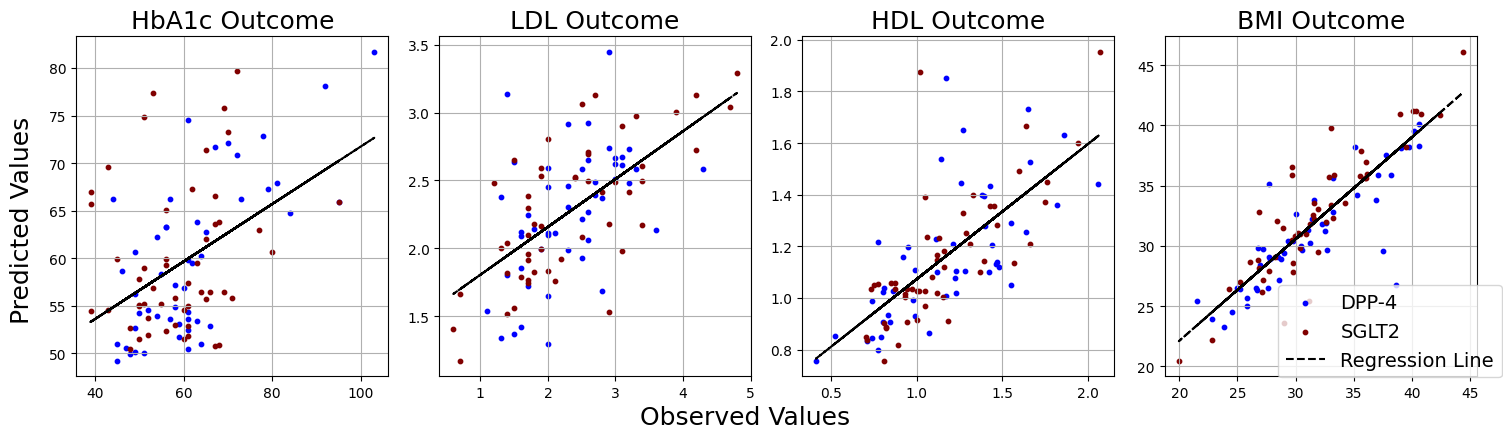

In [5]:
import matplotlib.pyplot as plt
import numpy as np


# Assuming Y_test and y_pred are your true and predicted values for multiple features
# Replace Y_test and y_pred with your actual variables
def plot_actual_pred(df, pred_, drug_class):

    # Number of target features
    num_targets = df.shape[1]
    #names = df.columns.tolist()
    # rearrange this names list if any changes to df response column order
    names = ['HbA1c Outcome', 'LDL Outcome', 'HDL Outcome', 'BMI Outcome']
    # Create subplots for each target feature
    fig, axes = plt.subplots(nrows=1, ncols=num_targets, figsize=(15, 5))

    # Set a common title
    #fig.suptitle('Observed vs. Predicted Values', fontsize= 14)
    colors = ['blue', 'maroon'] 
    scatter_plots = []
    # Plot each target feature separately
    for i, val in enumerate(names):
        ax = axes[i] if num_targets > 1 else axes  # Handle the case when there's only one target

        for idx, drug in enumerate(np.unique(drug_class)):
            if idx==0:
                drug_name = 'DPP-4'
            else: drug_name = 'SGLT2'
            indices = np.where(drug_class == drug)[0]
            scatter = ax.scatter(df.iloc[indices, i], pred_[indices, i], marker='o', c=colors[idx], s=10, cmap='coolwarm', label=f'{drug_name}')
            scatter_plots.append(scatter)  # Store the scatter plot object
        
        #scatter = ax.scatter(df.iloc[:, i], pred_[:, i], marker='o', s=10, c=drug_class ,cmap='coolwarm', label=f'Target {i + 1} Data Points')
        regression_line = ax.plot(df.iloc[:, i], np.poly1d(np.polyfit(df.iloc[:, i], pred_[:, i], 1))(df.iloc[:, i]), color='black', linestyle='--', label=f'Regression Line')
        #sns.regplot(x=df.iloc[:, i], y=pred_[:, i], ax=ax, scatter=False, color='black', label='Regression Line', ci=95)

        #ax.set_xlabel(f'Observed Values', fontsize=18)
        #ax.set_ylabel(f'Predicted Values',fontsize=18)
        
        # Set the subplot title
        ax.set_title(f'{val}', fontsize=18)
        
        ax.grid(True)
        
    # Set common X and Y axis labels
    fig.supxlabel('Observed Values', fontsize=18, y=0.08)
    fig.supylabel('Predicted Values', fontsize=18, x=0.01)

    handles, labels = ax.get_legend_handles_labels()

    # Create legend outside the loop
    fig.legend(handles, labels, loc=(0.85, 0.14), fontsize=14)
    # Adjust layout for better appearance
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

    # Save the figure with higher resolution
    plt.savefig('../resources/img/MultiOutput_Scatterplot.jpeg', dpi=300, bbox_inches='tight')

    plt.show()

y_pred = model.predict(X_test)
y_pred_train = model.predict(X_train)

plot_actual_pred(Y_test, y_pred, X_test['drug_class'])
#plot_actual_pred(Y_train, y_pred_train)
# Assuming Y_test and y_pred are your true and predicted values for multiple features
# Replace Y_test and y_pred with your actual variables


In [6]:
#plot_actual_pred(Y_train, y_pred_train, X_train['drug_class'])

# SHAP

In [7]:
# print the JS visualization code to the notebook
if (isshap):
    explainer = shap.KernelExplainer(model=model.predict, data=X_train, link="identity")

    # Note: We are limiting to the first 50 training examples since it takes time to calculate the full number of sampels
    shap_values = explainer.shap_values(X=X_test[selected_list])

    shap.initjs()
def get_shap_label(Y_test, val):
    # Create the list of all labels for the drop down list
    list_of_labels = Y_test.columns.to_list()

    # Create a list of tuples so that the index of the label is what is returned
    tuple_of_labels = list(zip(list_of_labels, range(len(list_of_labels))))

    # Create a widget for the labels and then display the widget
    current_label = widgets.Dropdown(
        options=tuple_of_labels, value=val, description="Select Label:"
    )

    # Display the dropdown list (Note: access index value with 'current_label.value')
    return list_of_labels, current_label


In [8]:
if (isshap):
    list_of_labels, current_label = get_shap_label(Y_test, 3)

In [9]:
if (isshap):
    print(current_label)

In [10]:
if (isshap):
    print(X_test.columns)

In [11]:
if (isshap):
    X_test_fe = X_test.rename(columns={
    'P_Krea': 'Creatinine',
    'bmi': 'Baseline BMI',
    'drug_class':'Drug class',
    'eGFR':'Glomerular filtration rate',
    'gluk':'Glucose',
    'hba1c_bl_18m':'HbA1c 6-18 months before',
    'hba1c_bl_6m':'Baseline HbA1c',
    'hdl':'Baseline HDL',
    'ika':'Age',
    'ldl':'Baseline LDL',
    'obese':'Obese',
    't2d_dur_y':'T2D Duration (years)',
    'trigly':'Triglycerides'
    }, inplace=False)
    

In [12]:

if (isshap):
    
    print(f"Current Label Shown: {list_of_labels[current_label.value]}\n")

    shap.summary_plot(
        shap_values=shap_values[current_label.value], features=X_test_fe, show=False, plot_size=[15,15]
    )

    fig, ax = plt.gcf(), plt.gca()
    ax.tick_params(labelsize=24)
    ax.set_xlabel("SHAP value (impact on model output)", fontsize=24)

    cb_ax = fig.axes[1]
    cb_ax.tick_params(labelsize=24)
    cb_ax.set_ylabel("Feature value", fontsize=24)

    plt.savefig('../resources/img/bmi_fs.jpeg' ,bbox_inches='tight', dpi=300)

    plt.show()

    #high positive SHAP value for a specific instance, 
    #means that increasing the value of that feature would tend to increase the predicted output 
    #of the regression model for that instance.

In [13]:
# Decision plot
# The x-axis represents the model’s output.
# All SHAP values are relative to the model’s expected value (base value)
# the features are ordered by the importance. (The importance is calculated over the observations plotted. This is usually different than the importance ordering for the entire dataset)
# At the top of the plot, each line strikes the x-axis at its corresponding observation’s predicted value. 
# Moving from the bottom of the plot to the top, SHAP values for each feature are added to the model’s base value

#decision_plot_index = 150 # 160
#print('real values : ', Y_test.iloc[decision_plot_index].values)
#print('predicted values : ', model.predict(X_test.iloc[[decision_plot_index]]))
      
#shap.decision_plot(explainer.expected_value[current_label.value],
#                   shap_values[current_label.value][decision_plot_index],
#                   features = X_test_before_scale[selected_list].iloc[decision_plot_index])


In [14]:
#X_test_before_scale

In [15]:
#X_test

In [16]:
#check index are in same order
#index_order_same = (X_test.index == X_test_before_scale.index).all()

#if index_order_same:
#    print("The index of the two DataFrames are in the same order.")
#else:
#    print("The index of the two DataFrames are not in the same order.")

In [17]:
# make copies of test dataset
# drug classes after normalization
# 0 = GLP-1 - 2
# 0.5 = DPP-4 -3
# 1 = SGLT2 - 4

if(is_train_with_all):
    sglt_val = 0.375
    dpp_val = 0.25
else:
    sglt_val = 1
    dpp_val = 0

X = X_test.copy()
X_test_copy = X_test.copy()
X_test_copy['assigned_drug_hba1c'] = np.nan
X_test_copy['predicted_change_hba1c'] = np.nan
X_test_copy['assigned_drug_ldl'] = np.nan
X_test_copy['predicted_change_ldl'] = np.nan
X_test_copy['assigned_drug_hdl'] = np.nan
X_test_copy['predicted_change_hdl'] = np.nan
X_test_copy['assigned_drug_bmi'] = np.nan
X_test_copy['predicted_change_bmi'] = np.nan

assigned_drug_class_0 = np.nan
assigned_drug_class_1 = np.nan
assigned_drug_class_2 = np.nan
assigned_drug_class_3 = np.nan
max_change_0 = np.nan
max_change_1 = np.nan
max_change_2 = np.nan
max_change_3 = np.nan
    
for index, row in X.iterrows():
    drug_class = row['drug_class']    
    pred_original = model.predict(row.values[None])[0]
    pred_sglt, pred_dpp = pred_all(model, row, drug_class) 
    
    for j in range(Y_train.shape[1]):
        variable_change_name = f"max_change_{j}"
        variable_drug_name = f"assigned_drug_class_{j}"
        
        if (Y_train.iloc[:,j].name == 'hdl_12m'):
            temp_max_change, temp_assigned_drug_class = find_highest_respponse_value(pred_sglt[j], pred_dpp[j])
        else:
            temp_max_change, temp_assigned_drug_class = find_lowest_respponse_value(pred_sglt[j], pred_dpp[j])
        # Update the original variables
        globals()[variable_change_name] = temp_max_change
        globals()[variable_drug_name] = temp_assigned_drug_class
    
#     print('actual: ', drug_class, 'assigned: ', assigned_drug_class_0)
    X_test_copy.at[index, 'assigned_drug_hba1c'] = assigned_drug_class_0
    X_test_copy.at[index, 'predicted_change_hba1c'] = max_change_0
    
    X_test_copy.at[index, 'assigned_drug_ldl'] = assigned_drug_class_1
    X_test_copy.at[index, 'predicted_change_ldl'] = max_change_1
    
    X_test_copy.at[index, 'assigned_drug_hdl'] = assigned_drug_class_2
    X_test_copy.at[index, 'predicted_change_hdl'] = max_change_2
    
    X_test_copy.at[index, 'assigned_drug_bmi'] = assigned_drug_class_3
    X_test_copy.at[index, 'predicted_change_bmi'] = max_change_3


denormalized_test_data = scaler.inverse_transform(X_test_original)
denormalized_test_df = pd.DataFrame(denormalized_test_data, columns=X_test_original.columns)
denormalized_test_df = denormalized_test_df.drop(['drug_class'], axis = 1)

data = denormalized_test_df
X_test_ = X_test_copy.copy()
X_test_= X_test_.reset_index()
Y_test = pd.DataFrame(Y_test)
Y_test = Y_test.reset_index()

data[response_variable_list] = Y_test[response_variable_list]

data['assigned_drug_hba1c'] = X_test_['assigned_drug_hba1c']
data['predicted_change_hba1c'] = X_test_['predicted_change_hba1c']
data['assigned_drug_ldl'] = X_test_['assigned_drug_ldl']
data['predicted_change_ldl'] = X_test_['predicted_change_ldl']
data['assigned_drug_hdl'] = X_test_['assigned_drug_hdl']
data['predicted_change_hdl'] = X_test_['predicted_change_hdl']
data['assigned_drug_bmi'] = X_test_['assigned_drug_bmi']
data['predicted_change_bmi'] = X_test_['predicted_change_bmi']
data['drug_class'] = X_test_['drug_class']

# save data to csv
data.to_csv('../resources/output/pred_drug_classes.csv')

# drug classes after normalization
# 0 = GLP-1 
# 0.5 = DPP-4 
# 1 = SGLT2

# 2=GLP-1 analogues (A10BJ)
# 3=DPP-4 inhibitors (A10BH)
# 4=SGLT2 inhibitors (A10BK)

dpp_strata_hba1c = data[(data['assigned_drug_hba1c'] == dpp_val)]
sglt_strata_hba1c = data[(data['assigned_drug_hba1c'] == sglt_val)] 

dpp_strata_ldl = data[(data['assigned_drug_ldl'] == dpp_val)]
sglt_strata_ldl = data[(data['assigned_drug_ldl'] == sglt_val)] 

dpp_strata_hdl = data[(data['assigned_drug_hdl'] == dpp_val)]
sglt_strata_hdl = data[(data['assigned_drug_hdl'] == sglt_val)] 

dpp_strata_bmi = data[(data['assigned_drug_bmi'] == dpp_val)]
sglt_strata_bmi = data[(data['assigned_drug_bmi'] == sglt_val)] 

dpp_strata_actual = data[(data['drug_class'] == dpp_val)]
sglt_strata_actual = data[(data['drug_class'] == sglt_val)] 


In [18]:
print(' Sample count in test data')
print(' number of dpp4 samples in test dataset : ', dpp_strata_actual.shape[0])
print(' number of sglt2 samples in test dataset : ', sglt_strata_actual.shape[0])

print(' \n Assigned sample count: HBA1C')

print(' number of dpp4 assigned : ', dpp_strata_hba1c.shape[0])
print(' number of sglt2 assigned : ', sglt_strata_hba1c.shape[0])

print(' \n Assigned sample count: LDL')

print(' number of dpp4 assigned : ', dpp_strata_ldl.shape[0])
print(' number of sglt2 assigned : ', sglt_strata_ldl.shape[0])

print(' \n Assigned sample count: HDL')

print(' number of dpp4 assigned : ', dpp_strata_hdl.shape[0])
print(' number of sglt2 assigned : ', sglt_strata_hdl.shape[0])

print(' \n Assigned sample count: BMI')

print(' number of dpp4 assigned : ', dpp_strata_bmi.shape[0])
print(' number of sglt2 assigned : ', sglt_strata_bmi.shape[0])



 Sample count in test data
 number of dpp4 samples in test dataset :  49
 number of sglt2 samples in test dataset :  52
 
 Assigned sample count: HBA1C
 number of dpp4 assigned :  48
 number of sglt2 assigned :  53
 
 Assigned sample count: LDL
 number of dpp4 assigned :  29
 number of sglt2 assigned :  72
 
 Assigned sample count: HDL
 number of dpp4 assigned :  48
 number of sglt2 assigned :  53
 
 Assigned sample count: BMI
 number of dpp4 assigned :  14
 number of sglt2 assigned :  87


In [19]:
# glp_strata - check concordant and discordant
# 0 = GLP-1 
# 0.5 = DPP-4 
# 1 = SGLT2
    
print('HBA1C')
(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
    concordant_sglt_hba1c, discordant_sglt_dpp_hba1c ) = get_concordant_discordant(dpp_strata_hba1c,sglt_strata_hba1c, data,
                                                                                   dpp_strata_actual, sglt_strata_actual,
                                                                               variable_name = 'assigned_drug_hba1c')
print('LDL')
(concordant_dpp_ldl, discordant_dpp_sglt_ldl,
    concordant_sglt_ldl, discordant_sglt_dpp_ldl ) = get_concordant_discordant(dpp_strata_ldl,sglt_strata_ldl, data,
                                                                                   dpp_strata_actual, sglt_strata_actual,
                                                                               variable_name = 'assigned_drug_ldl')
print('HDL')
(concordant_dpp_hdl, discordant_dpp_sglt_hdl,
    concordant_sglt_hdl, discordant_sglt_dpp_hdl ) = get_concordant_discordant(dpp_strata_hdl,sglt_strata_hdl, data,
                                                                                   dpp_strata_actual, sglt_strata_actual,
                                                                                 variable_name = 'assigned_drug_hdl')
print('BMI') 
(concordant_dpp_bmi, discordant_dpp_sglt_bmi,
    concordant_sglt_bmi, discordant_sglt_dpp_bmi ) = get_concordant_discordant(dpp_strata_bmi,sglt_strata_bmi, data,
                                                                                   dpp_strata_actual, sglt_strata_actual,
                                                                                  variable_name = 'assigned_drug_bmi')

    


HBA1C
 =========== Total number of samples assigned by the model VS Total number of samples in original test data
DPP samples  48 49
SGLT samples  53 52


Category    Real value    Predicted value    Count    Percentage of Predicted cases
----------  ------------  -----------------  -------  -------------------------------
Concordant  SGLT          SGLT               27       50.94%
Discordant  DPP           SGLT               26       52.08%

Concordant  DPP           DPP                23       47.92%
Discordant  SGLT          DPP                25       49.06%


LDL
 =========== Total number of samples assigned by the model VS Total number of samples in original test data
DPP samples  29 49
SGLT samples  72 52


Category    Real value    Predicted value    Count    Percentage of Predicted cases
----------  ------------  -----------------  -------  -------------------------------
Concordant  SGLT          SGLT               36       50.00%
Discordant  DPP           SGLT              

# Remove outliers in our model predicted change

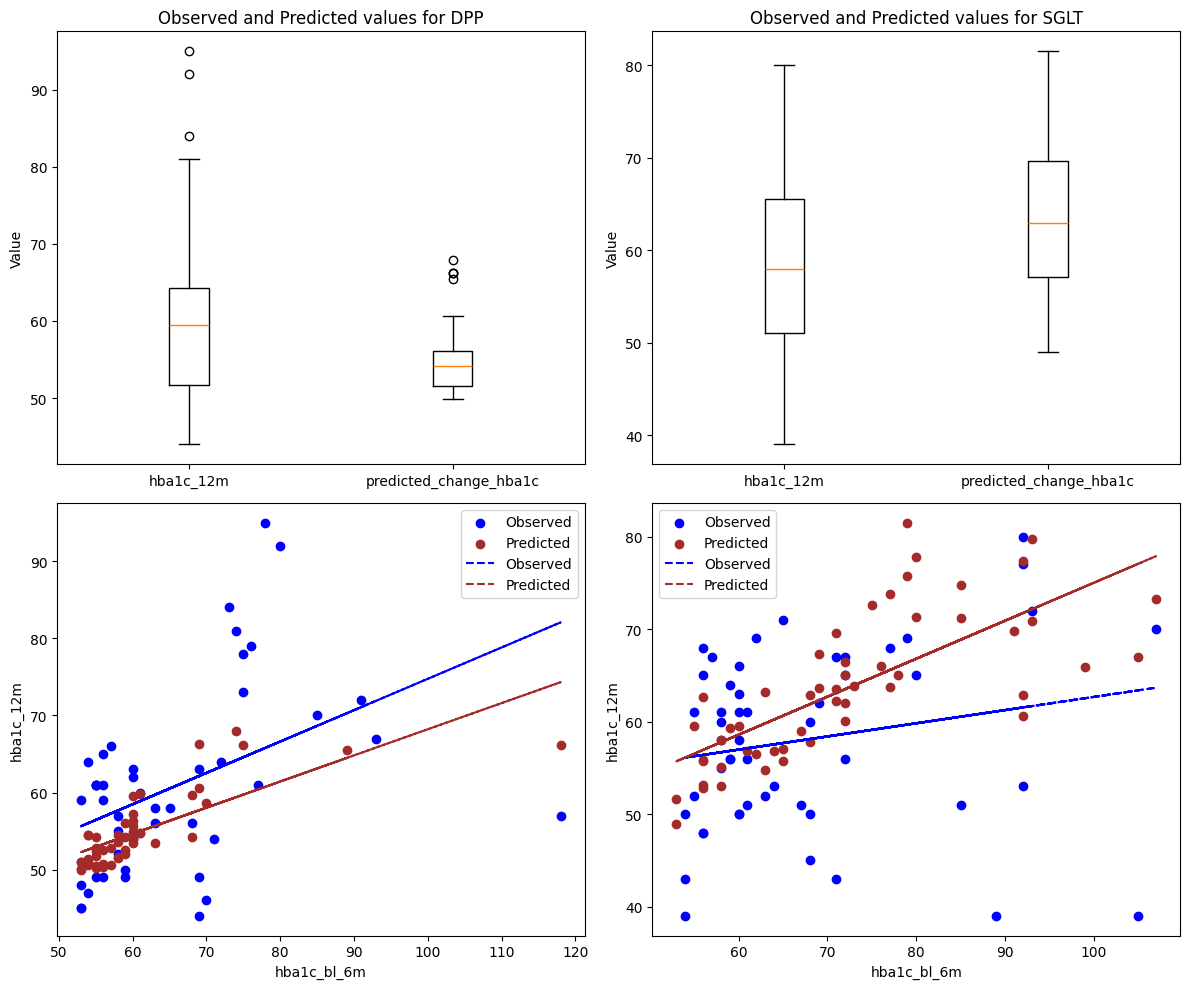

In [20]:

df_ = drug_class_visualization(dpp_strata_hba1c, dpp_strata_actual, sglt_strata_hba1c,sglt_strata_actual,
                                     response_variable='hba1c_12m', 
                                     predicted_change='predicted_change_hba1c',
                                     assigned_drug='assigned_drug_hba1c',
                                     baseline_val='hba1c_bl_6m')



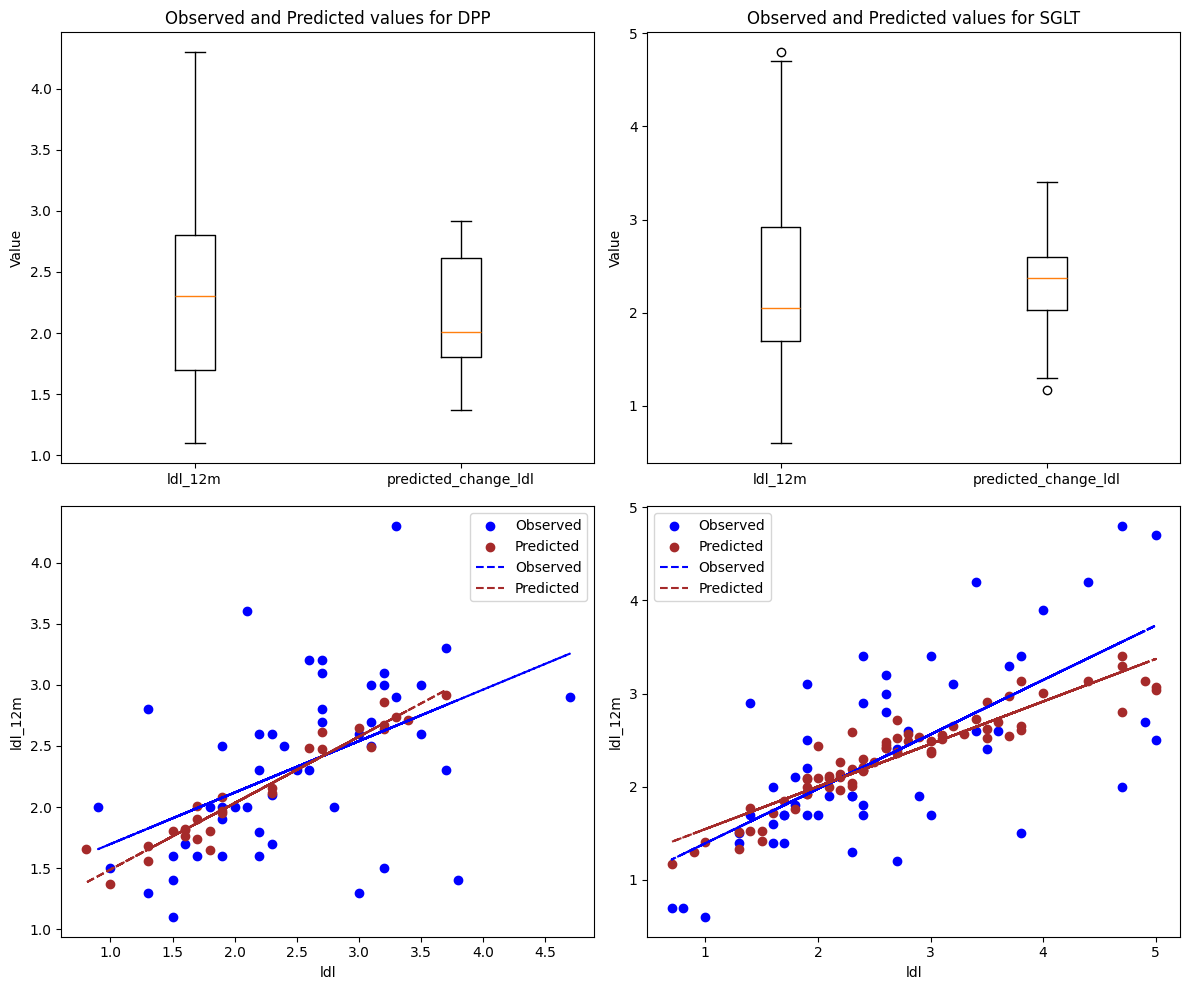

In [21]:
df_ldl_ = drug_class_visualization(dpp_strata_ldl, dpp_strata_actual, sglt_strata_ldl,sglt_strata_actual,
                                     response_variable='ldl_12m', 
                                     predicted_change='predicted_change_ldl',
                                     assigned_drug='assigned_drug_ldl',
                                     baseline_val='ldl')


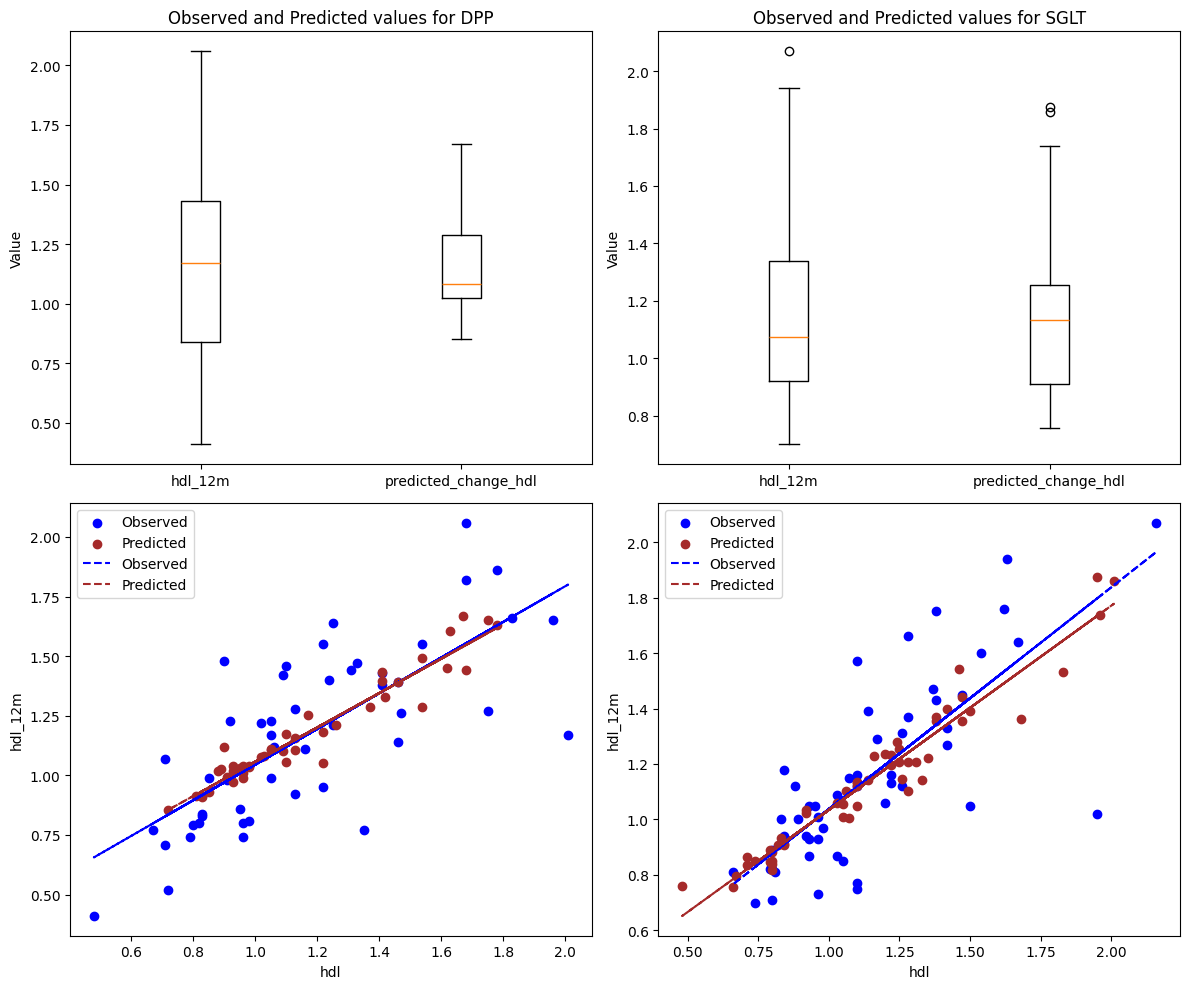

In [22]:
df_hdl_ = drug_class_visualization(dpp_strata_hdl, dpp_strata_actual, sglt_strata_hdl,sglt_strata_actual,
                                     response_variable='hdl_12m', 
                                     predicted_change='predicted_change_hdl',
                                     assigned_drug='assigned_drug_hdl',
                                     baseline_val='hdl')


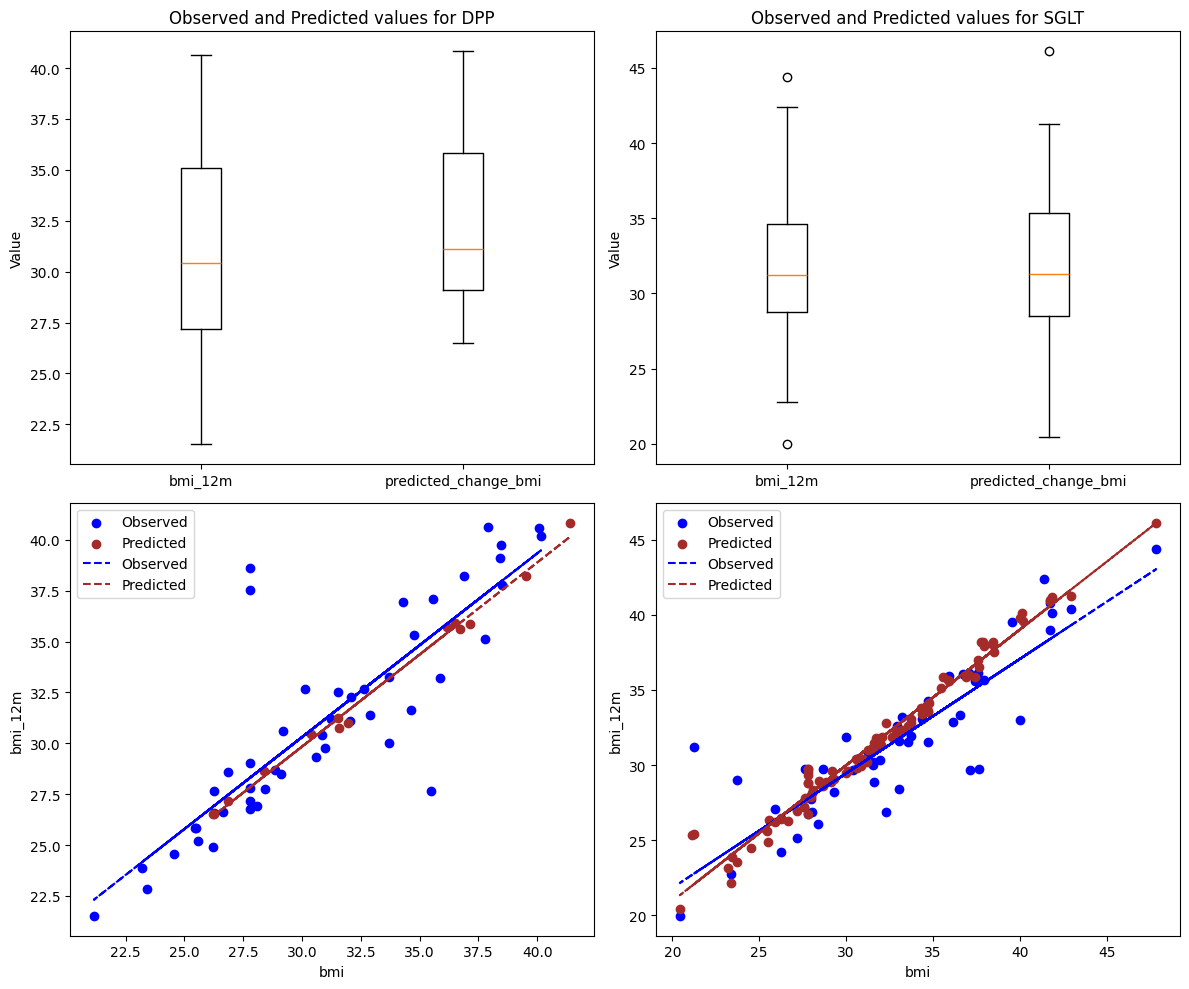

In [23]:
df_bmi_ = drug_class_visualization(dpp_strata_bmi, dpp_strata_actual, sglt_strata_bmi,sglt_strata_actual,
                                     response_variable='bmi_12m', 
                                     predicted_change='predicted_change_bmi',
                                     assigned_drug='assigned_drug_bmi',
                                     baseline_val='bmi')


In [24]:



dpp_df_hba1c = drug_class_outlier_remove(dpp_strata_hba1c, dpp_strata_actual, 'hba1c_12m','predicted_change_hba1c', 'assigned_drug_hba1c', 'hba1c_bl_6m')
sglt_df_hba1c = drug_class_outlier_remove(sglt_strata_hba1c, sglt_strata_actual,'hba1c_12m',
                                            'predicted_change_hba1c', 'assigned_drug_hba1c', 'hba1c_bl_6m')
    
dpp_df_ldl = drug_class_outlier_remove(dpp_strata_ldl, dpp_strata_actual, 'ldl_12m',
                                         'predicted_change_ldl', 'assigned_drug_ldl', 'ldl')
sglt_df_ldl = drug_class_outlier_remove(sglt_strata_ldl, sglt_strata_actual, 'ldl_12m',
                                          'predicted_change_ldl', 'assigned_drug_ldl', 'ldl')
    
dpp_df_hdl = drug_class_outlier_remove(dpp_strata_hdl, dpp_strata_actual, 'hdl_12m',
                                         'predicted_change_hdl', 'assigned_drug_hdl', 'hdl')
sglt_df_hdl = drug_class_outlier_remove(sglt_strata_hdl, sglt_strata_actual, 'hdl_12m',
                                          'predicted_change_hdl', 'assigned_drug_hdl', 'hdl')
    
dpp_df_bmi = drug_class_outlier_remove(dpp_strata_bmi, dpp_strata_actual, 'bmi_12m',
                                         'predicted_change_bmi', 'assigned_drug_bmi', 'bmi')
sglt_df_bmi = drug_class_outlier_remove(sglt_strata_bmi, sglt_strata_actual, 'bmi_12m',
                                          'predicted_change_bmi', 'assigned_drug_bmi', 'bmi')


In [25]:

print('HBA1C')
(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
    concordant_sglt_hba1c, discordant_sglt_dpp_hba1c ) = get_concordant_discordant(dpp_df_hba1c,sglt_df_hba1c, data,
                                                                                   dpp_strata_actual, sglt_strata_actual,
                                                                                  variable_name = 'assigned_drug_hba1c')

print('\n============= HBA1C ===================')    
print_change_mean(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
            concordant_sglt_hba1c, discordant_sglt_dpp_hba1c, response_variable = 'hba1c_12m')

print('\n\n====== Average change of other 3 responses =========')
calculate_percentage_change_othre_responses(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
            concordant_sglt_hba1c, discordant_sglt_dpp_hba1c, 
            response_variable1='ldl_12m', response_variable2='hdl_12m', response_variable3='bmi_12m',
            baseline_val1='ldl',baseline_val2='hdl', baseline_val3='bmi',
            label1='LDL', label2='HDL', label3='BMI')
    
print('\n\n====== Percentage in Original data =========')
percentage_change_original_data(dpp_strata_actual, sglt_strata_actual,baseline_val='hba1c_bl_6m', response_variable = 'hba1c_12m')


calculate_change_diff(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c, concordant_sglt_hba1c, discordant_sglt_dpp_hba1c,
                     'hba1c_12m', 'hba1c_bl_6m', 'predicted_change_hba1c')


HBA1C
 =========== Total number of samples assigned by the model VS Total number of samples in original test data
DPP samples  48 49
SGLT samples  53 52


Category    Real value    Predicted value    Count    Percentage of Predicted cases
----------  ------------  -----------------  -------  -------------------------------
Concordant  SGLT          SGLT               27       50.94%
Discordant  DPP           SGLT               26       52.08%

Concordant  DPP           DPP                23       47.92%
Discordant  SGLT          DPP                25       49.06%



============= HBA1C ===================
-------- Average Change --------
Category    Real value    Predicted value    Average
----------  ------------  -----------------  ------------------
Concordant  SGLT          SGLT               62.592592592592595
Discordant  DPP           SGLT               66.3076923076923

Concordant  DPP           DPP                56.08695652173913
Discordant  SGLT          DPP                54

In [26]:

print('LDL')
(concordant_dpp_ldl, discordant_dpp_sglt_ldl,
    concordant_sglt_ldl, discordant_sglt_dpp_ldl ) = get_concordant_discordant(dpp_df_ldl,sglt_df_ldl, data,
                                                                                   dpp_strata_actual, sglt_strata_actual,
                                                                                  variable_name = 'assigned_drug_ldl')

print('\n============= LDL ===================')    
print_change_mean(concordant_dpp_ldl, discordant_dpp_sglt_ldl,
            concordant_sglt_ldl, discordant_sglt_dpp_ldl, response_variable = 'ldl_12m')


print('\n\n====== Average change of other 3 responses =========')
calculate_percentage_change_othre_responses(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
            concordant_sglt_hba1c, discordant_sglt_dpp_hba1c, 
            response_variable1='hba1c_12m', response_variable2='hdl_12m', response_variable3='bmi_12m',
            baseline_val1='hba1c_bl_6m',baseline_val2='hdl', baseline_val3='bmi',
            label1='HBA1C', label2='HDL', label3='BMI')

print('\n\n====== Percentage in Original data =========')
percentage_change_original_data(dpp_strata_actual, sglt_strata_actual, baseline_val='ldl', response_variable = 'ldl_12m')


calculate_change_diff(concordant_dpp_ldl, discordant_dpp_sglt_ldl, concordant_sglt_ldl, discordant_sglt_dpp_ldl,
                     'ldl_12m', 'ldl', 'predicted_change_ldl')


LDL
 =========== Total number of samples assigned by the model VS Total number of samples in original test data
DPP samples  29 49
SGLT samples  72 52


Category    Real value    Predicted value    Count    Percentage of Predicted cases
----------  ------------  -----------------  -------  -------------------------------
Concordant  SGLT          SGLT               36       50.00%
Discordant  DPP           SGLT               36       55.17%

Concordant  DPP           DPP                13       44.83%
Discordant  SGLT          DPP                16       50.00%



============= LDL ===================
-------- Average Change --------
Category    Real value    Predicted value    Average
----------  ------------  -----------------  -----------------
Concordant  SGLT          SGLT               2.538888893193669
Discordant  DPP           SGLT               2.29444443848398

Concordant  DPP           DPP                2.399999976158142
Discordant  SGLT          DPP                1.868749

In [27]:

print('HDL')
(concordant_dpp_hdl, discordant_dpp_sglt_hdl,
    concordant_sglt_hdl, discordant_sglt_dpp_hdl ) = get_concordant_discordant(dpp_df_hdl,sglt_df_hdl, data,
                                                                                   dpp_strata_actual, sglt_strata_actual,
                                                                                  variable_name = 'assigned_drug_hdl')
print('\n============= HDL ===================')    
print_change_mean(concordant_dpp_hdl, discordant_dpp_sglt_hdl,
            concordant_sglt_hdl, discordant_sglt_dpp_hdl, response_variable = 'hdl_12m')


print('\n\n====== Average change of other 3 responses =========')
calculate_percentage_change_othre_responses(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
            concordant_sglt_hba1c, discordant_sglt_dpp_hba1c, 
            response_variable1='hba1c_12m', response_variable2='ldl_12m', response_variable3='bmi_12m',
            baseline_val1='hba1c_bl_6m',baseline_val2='ldl', baseline_val3='bmi',
            label1='HBA1C', label2='LDL', label3='BMI')

print('\n\n====== Percentage in Original data =========')
percentage_change_original_data(dpp_strata_actual, sglt_strata_actual, baseline_val='hdl', response_variable = 'hdl_12m')


calculate_change_diff(concordant_dpp_hdl, discordant_dpp_sglt_hdl, concordant_sglt_hdl, discordant_sglt_dpp_hdl,
                     'hdl_12m', 'hdl', 'predicted_change_hdl')


HDL
 =========== Total number of samples assigned by the model VS Total number of samples in original test data
DPP samples  47 49
SGLT samples  53 52


Category    Real value    Predicted value    Count    Percentage of Predicted cases
----------  ------------  -----------------  -------  -------------------------------
Concordant  SGLT          SGLT               27       50.94%
Discordant  DPP           SGLT               26       51.06%

Concordant  DPP           DPP                23       48.94%
Discordant  SGLT          DPP                24       49.06%



============= HDL ===================
-------- Average Change --------
Category    Real value    Predicted value    Average
----------  ------------  -----------------  ------------------
Concordant  SGLT          SGLT               1.1081481399359527
Discordant  DPP           SGLT               1.145769232740769

Concordant  DPP           DPP                1.1986956440884133
Discordant  SGLT          DPP                1.16

In [28]:

print('BMI')
(concordant_dpp_bmi, discordant_dpp_sglt_bmi,
    concordant_sglt_bmi, discordant_sglt_dpp_bmi ) = get_concordant_discordant(dpp_df_bmi,sglt_df_bmi, data,
                                                                                   dpp_strata_actual, sglt_strata_actual,
                                                                                  variable_name = 'assigned_drug_bmi')

print('\n============= BMI ===================')    
print_change_mean(concordant_dpp_bmi, discordant_dpp_sglt_bmi,
            concordant_sglt_bmi, discordant_sglt_dpp_bmi, response_variable = 'bmi_12m')

print('\n\n====== Average change of other 3 responses =========')
calculate_percentage_change_othre_responses(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
            concordant_sglt_hba1c, discordant_sglt_dpp_hba1c, 
            response_variable1='hba1c_12m', response_variable2='ldl_12m', response_variable3='hdl_12m',
            baseline_val1='hba1c_bl_6m',baseline_val2='ldl', baseline_val3='hdl',
            label1='HBA1C', label2='LDL', label3='HDL')

print('\n\n====== Percentage in Original data =========')
percentage_change_original_data(dpp_strata_actual, sglt_strata_actual,baseline_val='bmi',response_variable = 'bmi_12m')


calculate_change_diff(concordant_dpp_bmi, discordant_dpp_sglt_bmi, concordant_sglt_bmi, discordant_sglt_dpp_bmi,
                     'bmi_12m', 'bmi', 'predicted_change_bmi')


BMI
 =========== Total number of samples assigned by the model VS Total number of samples in original test data
DPP samples  14 49
SGLT samples  87 52


Category    Real value    Predicted value    Count    Percentage of Predicted cases
----------  ------------  -----------------  -------  -------------------------------
Concordant  SGLT          SGLT               42       48.28%
Discordant  DPP           SGLT               45       71.43%

Concordant  DPP           DPP                4        28.57%
Discordant  SGLT          DPP                10       51.72%



============= BMI ===================
-------- Average Change --------
Category    Real value    Predicted value    Average
----------  ------------  -----------------  ------------------
Concordant  SGLT          SGLT               31.45222623007638
Discordant  DPP           SGLT               31.347197638617622

Concordant  DPP           DPP                28.147499561309814
Discordant  SGLT          DPP                32.9

In [29]:
print('\n\n====== Percentage =========')
calculate_percentage_change(concordant_dpp_hba1c, discordant_dpp_sglt_hba1c,
            concordant_sglt_hba1c, discordant_sglt_dpp_hba1c, response_variable = 'hba1c_12m', baseline_val='hba1c_bl_6m')

print('\n\n====== Percentage =========')
calculate_percentage_change(concordant_dpp_ldl, discordant_dpp_sglt_ldl,
            concordant_sglt_ldl, discordant_sglt_dpp_ldl, response_variable = 'ldl_12m', baseline_val='ldl')

print('\n\n====== Percentage =========')
calculate_percentage_change(concordant_dpp_hdl, discordant_dpp_sglt_hdl,
            concordant_sglt_hdl, discordant_sglt_dpp_hdl, response_variable = 'hdl_12m', baseline_val='hdl')

print('\n\n====== Percentage =========')
calculate_percentage_change(concordant_dpp_bmi, discordant_dpp_sglt_bmi,
            concordant_sglt_bmi, discordant_sglt_dpp_bmi,  response_variable = 'bmi_12m', baseline_val='bmi' )




====== Percentage =========
Category    Real value    Predicted value    Mean % Change from Baseline    std     treatment difference
----------  ------------  -----------------  -----------------------------  ------  ----------------------
Concordant  SGLT          SGLT               -13.15%                        16.45%  -10.92%
Discordant  DPP           SGLT               -2.23%                         11.84%

Concordant  DPP           DPP                -6.22%                         15.40%  -0.78
Discordant  SGLT          DPP                -5.44%                         12.36%


====== Percentage =========
Category    Real value    Predicted value    Mean % Change from Baseline    std    treatment difference
----------  ------------  -----------------  -----------------------------  -----  ----------------------
Concordant  SGLT          SGLT               -0.36%                         0.95%  -0.19%
Discordant  DPP           SGLT               -0.18%                         0.7